In [2]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats
import pandas as pd
from sympy import *
import os

sys.path.append('../../External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax, add_header_to_ax

In [38]:
listdir = os.listdir("../StopwatchTimer/")
print(listdir)
anton_df = pd.read_table("../StopwatchTimer/pendulanton3.dat", names=["measurement", "TimeAnton"])
ida_df = pd.read_table("../StopwatchTimer/PendulumIda.dat", names=["measurement", "TimeIda"])[:-1]
philip_df = pd.read_table("../StopwatchTimer/PendulumPhilip2.dat", names=["measurement", "TimePhilip"])
df = ida_df.copy()
# df["TimeAnton"] = anton_df["TimeAnton"]
df["TimePhilip"] = philip_df["TimePhilip"]
display(df)

['pendulanton.dat', 'Pendulanton2.dat', 'Pendulanton3.dat', 'PendulumIda.dat', 'pendulumphilip.dat', 'PendulumPhilip2.dat', 'stopwatch.ipynb', 'stopwatch_py3.py']


,measurement,TimeIda,TimePhilip
0,1,10.6462,4.1431
1,2,19.4112,12.8467
2,3,27.9703,21.4326
3,4,36.6791,30.0420
4,5,45.1562,38.7370
5,6,53.6800,47.2866
6,7,62.3983,55.8825
7,8,71.0822,64.5202
8,9,79.6055,73.1565
9,10,88.2538,81.7858


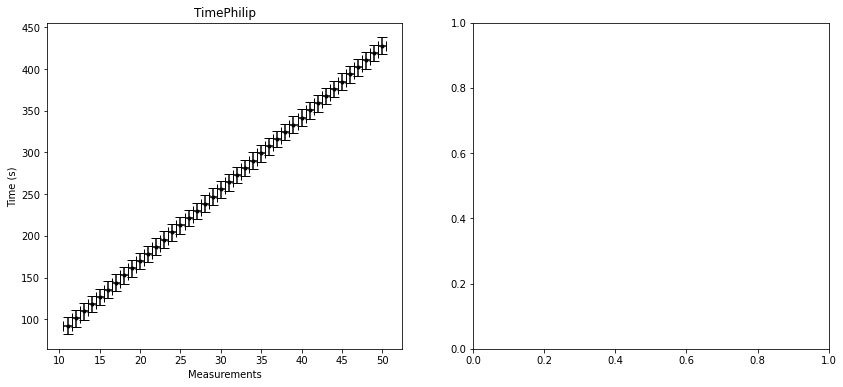

In [23]:
fig, axes = plt.subplots(1, 2, figsize = (14,6), facecolor = "white")

titles = df.keys()[1:]
for title, ax in zip(titles, axes):
    ax.errorbar(df["measurement"], df[title], xerr = 0.5, yerr = 10, ecolor = "k", fmt = ".", color = "k", capsize = 5)
    ax.set_title(title)
    ax.set_ylabel("Time (s)")
    ax.set_xlabel("Measurements")

In [48]:
# fit data to linear function
def linear_function(x, a, b):
    return a * x + b
    chi2_object = Chi2Regression(fit_function, x, y, ey)
    chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

# Alternatively, you can define Chi2 calculation:
def chi2_owncalc(a, b) :
    y_fit = linear_function(x, a, b)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2

datasetnames = df.keys()[1:]

errors = [0.057, 0.056, 0.1]

array_b = np.zeros(datasetnames.shape)
array_a = np.zeros(datasetnames.shape)
array_b_err = np.zeros(datasetnames.shape)
array_a_err = np.zeros(datasetnames.shape) 
array_Chi2 = np.zeros(datasetnames.shape)
array_Prob = np.zeros(datasetnames.shape)
array_Ndof = np.zeros(datasetnames.shape)

for i, datatilte in enumerate(df.keys()[1:]):
    x = df["measurement"]
    ex = np.zeros_like(x)
    # Note how we include uncertainty in y - by simply adding a Guassian number to the "theoretical value".
    y = df[datatilte]
    ey = errors[i]
    
    chi2_object = Chi2Regression(linear_function, x, y, ey)
    chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

    # Here we let Minuit know, what to minimise, how, and with what starting parameters:   
    minuit = Minuit(chi2_object, a=7.0, b=0.0)     # External Functions
    # minuit = Minuit(chi2_owncalc, a=7.0, b=0.0)     # Own alternative

    # Perform the actual fit:
    minuit.migrad()

    # Extract the fitting parameters and their errors:
    a_fit = minuit.values['a']
    b_fit = minuit.values['b']
    sigma_a_fit = minuit.errors['a']
    sigma_b_fit = minuit.errors['b']

    Nvar = 2                     # Number of variables (alpha0 and alpha1)
    Ndof_fit = len(x) - Nvar   # Number of degrees of freedom = Number of data points - Number of variables

    # Get the minimal value obtained for the quantity to be minimised (here the Chi2)
    Chi2_fit = minuit.fval                          # The chi2 value
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

    # Fill the arrays with fit results (to produce plots of these at the end):
    array_Ndof[i] = Ndof_fit
    array_a_err[i] = sigma_a_fit
    array_b_err[i] = sigma_b_fit
    array_a[i] = a_fit
    array_b[i] = b_fit
    array_Chi2[i] = Chi2_fit
    array_Prob[i] = Prob_fit

print(array_b, array_a, array_Chi2, array_Prob)


[ 2.15481208 -4.40269829] [8.60687498 8.60883029] [48.32788443 49.12392398] [0.45959326 0.42786835]


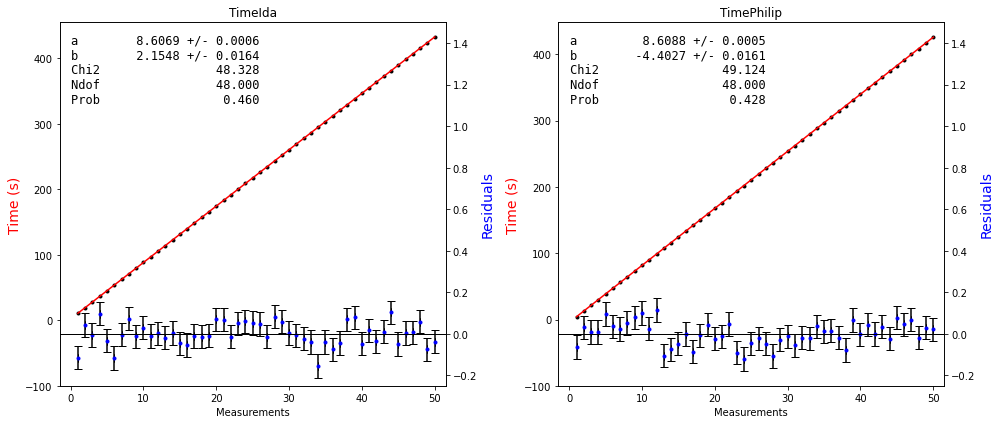

In [60]:


titles = df.keys()[1:]

residual = df[df.keys()[1:]] - np.array([linear_function(df["measurement"], array_a, array_b) for array_a, array_b in zip(array_a, array_b)]).T

N_datasets = len(titles)

fig, axes = plt.subplots(1, N_datasets, figsize = (14,6), facecolor = "white")

for title, ax, i in zip(titles, axes, range(N_datasets)):
    
    ax.errorbar(df["measurement"], df[title], xerr = 0, yerr = 1, ecolor = "k", fmt = ".", color = "k", capsize = 0, zorder = 0)
    ax.plot(df["measurement"], linear_function(df["measurement"], array_a[i], array_b[i]), color = "r", linewidth = 1.5)
    ymax = ax.get_ylim()[1]
    ax.set_ylim(-100, ymax)
    ax.set_title(title)
    ax.set_ylabel("Time (s)", color = "r", fontsize = 14)
    ax.set_xlabel("Measurements")
    ax.set_xlim(-1.5,51.5)
    
    
    sec_ax = ax.twinx()
    sec_ax.errorbar(df["measurement"], residual[title], xerr = 0, yerr = 0.056, ecolor = "k", fmt = ".", color = "b", capsize = 4, zorder = 0)
    sec_ax.set_ylim(-0.25,1.5)
    sec_ax.set_ylabel("Residuals", color = "b", fontsize = 14)
    sec_ax.hlines(0, -10, 60, color = "k", linewidth = 1)
    
    d = {
         "a": f"{array_a[i]:.4f} +/- {array_a_err[i]:.4f}",
         "b": f"{array_b[i]:.4f} +/- {array_b_err[i]:.4f}",
         "Chi2": array_Chi2[i],
         "Ndof": array_Ndof[i],
         "Prob": array_Prob[i]
         }
    
    text = nice_string_output(d)
    add_text_to_ax(0.03, 0.97, text, ax)
    
fig.tight_layout()
plt.show()

In [89]:
print()

0.0226577801207444


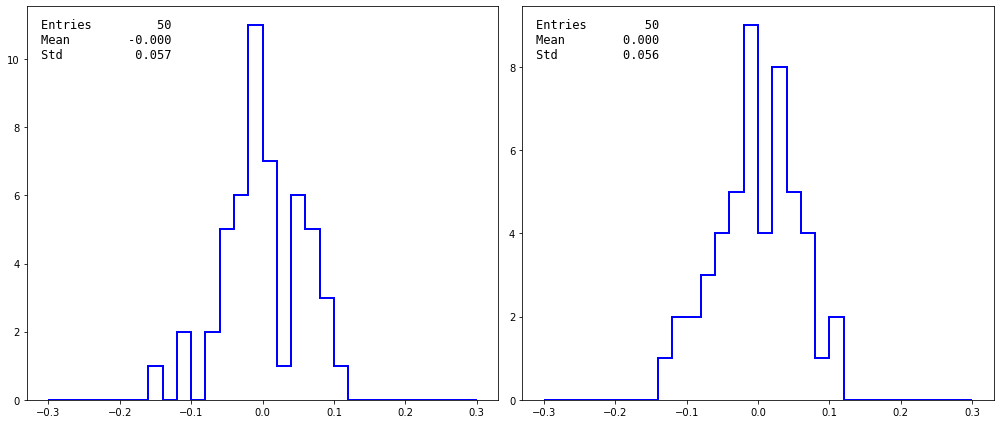

In [47]:
fig, axes = plt.subplots(1, 2, figsize = (14,6), facecolor = "white")

titles = df.keys()[1:]

for title, ax in zip(titles, axes):
    
    ax.hist(residual[title], bins = 30, histtype = "step", linewidth = 2, color ="b", range = (-0.3, 0.3))
    add_header_to_ax(residual[title], 0.03, 0.97, ax)

fig.tight_layout()



In [128]:
fake_data = pd.DataFrame({ "L": [14.012, 14.001, 14.007, 13.984, 13.992], "Lerr": [0.01, 0.02, 0.015, 0.02, 0.04]})
display(fake_data)

,L,Lerr
0,14.012,0.010
1,14.001,0.020
2,14.007,0.015
3,13.984,0.020
4,13.992,0.040


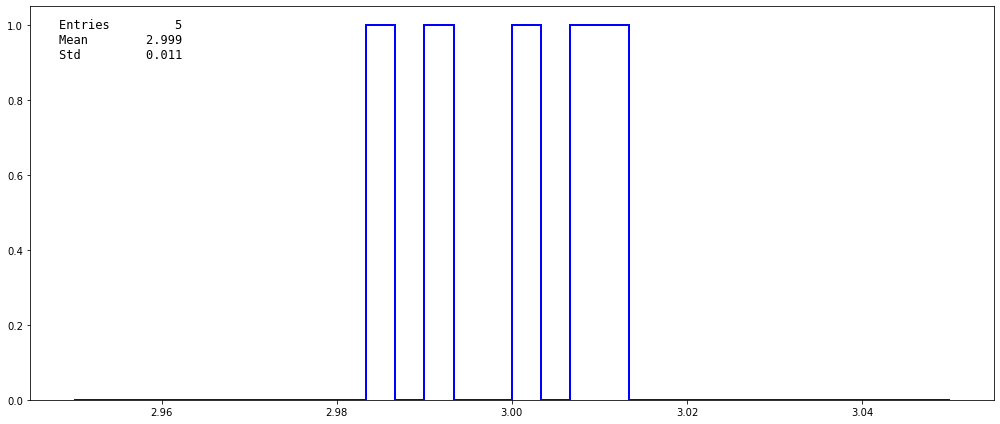

In [104]:
fig, ax = plt.subplots(1, 1, figsize = (14,6), facecolor = "white")
ax.hist(fake_data["L"], bins = 30, histtype = "step", linewidth = 2, color ="b", range = (2.95, 3.05))
add_header_to_ax(fake_data["L"], 0.03, 0.97, ax)

fig.tight_layout()
plt.show()

0.007058823529411765
0    1.28
1    0.09
2    0.52
3   -0.76
4   -0.18
dtype: float64


(array([1., 0., 1., 0., 1., 0., 1., 0., 0., 1.]),
 array([-0.76 , -0.556, -0.352, -0.148,  0.056,  0.26 ,  0.464,  0.668,
         0.872,  1.076,  1.28 ]),
 <BarContainer object of 10 artists>)

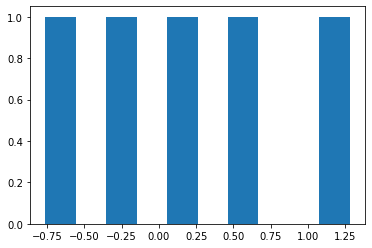

In [167]:
def weighted_mean(x, sigmax):
    return np.sum(x / sigmax**2) / np.sum(1 / sigmax ** 2)

def weighted_std(sigmax):
    return np.sqrt(1 / np.sum(1 / sigmax ** 2))

L_mean = weighted_mean(fake_data["L"], fake_data["Lerr"])
L_std = weighted_std(fake_data["Lerr"])
print(L_std)
z = (fake_data["L"] - np.mean(fake_data["L"])) / fake_data["Lerr"]
print(z)
plt.hist(z)

In [131]:
from sympy import *

In [166]:
L = Symbol("L")
T = Symbol("T")

g = L * (2 * np.pi / T) ** 2

g_sigma_L_con = lambdify([L, T], g.diff(L)**2 * L_std**2, 'numpy')(L_mean, array_a[0])
g_sigma_T_con = lambdify([L, T], g.diff(T)**2 * array_a_err[0]**2, "numpy")(L_mean, array_a[0])
print(g_sigma_L_con, g_sigma_T_con)
print(g_sigma_L_con + g_sigma_T_con)


2.4386033771906116e-05 2.4920786155085775e-05
4.9306819926991894e-05
